# IMPORTING LIBRARIES

In [634]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express  as px
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor,plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR


#IMPORTING DATA

In [635]:
df=pd.read_csv('/content/Store.csv')
df.head()

,Unnamed: 0,revenue,reach,local_tv,online,instore,person,event
0,845,45860.28,2,31694.91,2115,3296,8,non_event
1,483,63588.23,2,35040.17,1826,2501,14,special
2,513,23272.69,4,30992.82,1851,2524,6,special
3,599,45911.23,2,29417.78,2437,3049,12,special
4,120,36644.23,2,35611.11,1122,1142,13,cobranding


**Columns Description**

**reach:** tweet times (Wechat tweet or Twitter)  

**local_tv:** local TV advertising investment

**online:** online advertising investment

**instore:** in stores investment, for example posters and displays

**person:** store sales staff input

**event:** promotional events

# DATA CLEANING

In [636]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 0 to 984
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  985 non-null    int64  
 1   revenue     985 non-null    float64
 2   reach       985 non-null    int64  
 3   local_tv    929 non-null    float64
 4   online      985 non-null    int64  
 5   instore     985 non-null    int64  
 6   person      985 non-null    int64  
 7   event       985 non-null    object 
dtypes: float64(2), int64(5), object(1)
memory usage: 61.7+ KB


**Observation:** The dataframe has 8 features with int64, float64 and object data types. There are 985 observation with missing values on the local_tv column. Meanwhile from the eigth columnbs,unnamed: 0 column is a redundant column.

In [637]:
df.drop('Unnamed: 0', axis=1, inplace=True)

**Dropping redundant column**

# Exploratory Data Analysis

**Univariate Analysis**

---



**Density Plot of all The continous data**

array([[<Axes: ylabel='Density'>, <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>]], dtype=object)

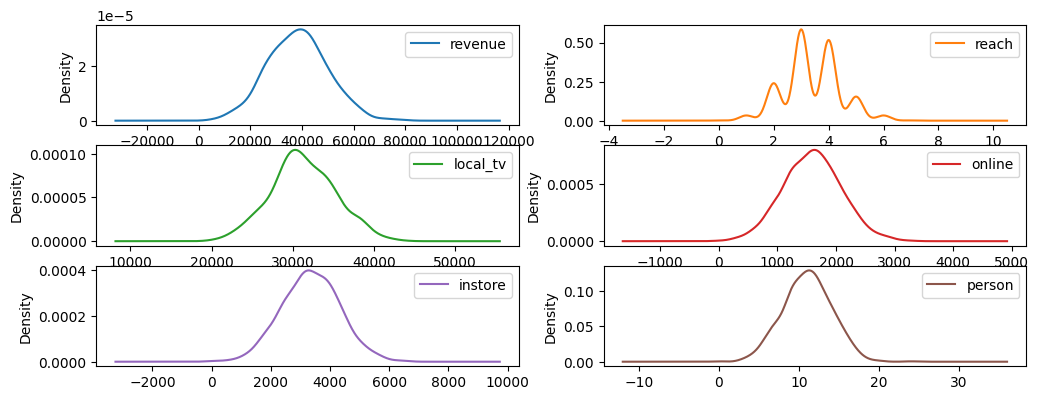

In [638]:
df.plot(kind='density', subplots=True,layout=(4,2) ,sharex=False, figsize=(12, 6))

**Observation:** Person, Online, location, instore and revenue are normally distribution. Meanwhile, reach column has many peaks.

**Bar Graph of the Counts of events held**

Text(0.5, 1.0, 'Counts of different events held')

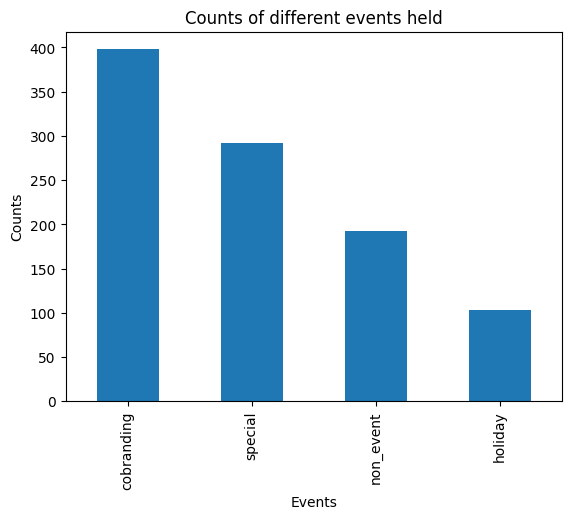

In [639]:
df['event'].value_counts().plot(kind='bar')
plt.xlabel('Events')
plt.ylabel('Counts')
plt.title('Counts of different events held')

**Observation** More cobranding events were held compared to special and holiday. However, there were also many times where there was no event held for markting. 

**Multivariate Analysis**

---



<ipython-input-640-4b208cf9896e>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

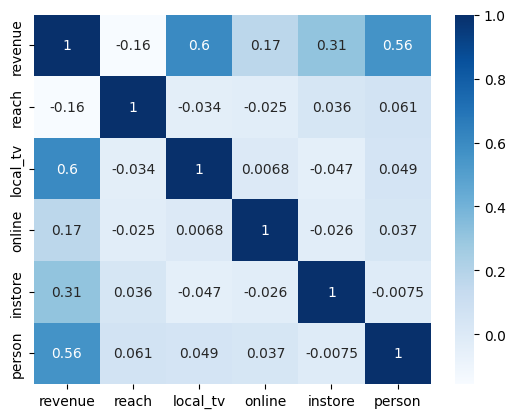

In [640]:
sns.heatmap(df.corr(),cmap="Blues", annot=True)

**Observation** There is no sign of Multicolinearity. However, there is a moderate positive correlation between advertisement through Local_tv and Revenue. Thus, the company should increase their investment on Local TV advertisement in order for them to harness more revenue. Moreover, An increase in store sales staff input has moderate positive correlation with Revenue.Thus, the company should also harness encourage person markerting. Lastly, There is a weak negative correlation between Revenue and number of tweets. The company should gain more insights into twitter to ensure that it doesn't hamper their revenue. Online and instore advertisement have weak positive correlation with revenue

<Axes: xlabel='online', ylabel='revenue'>

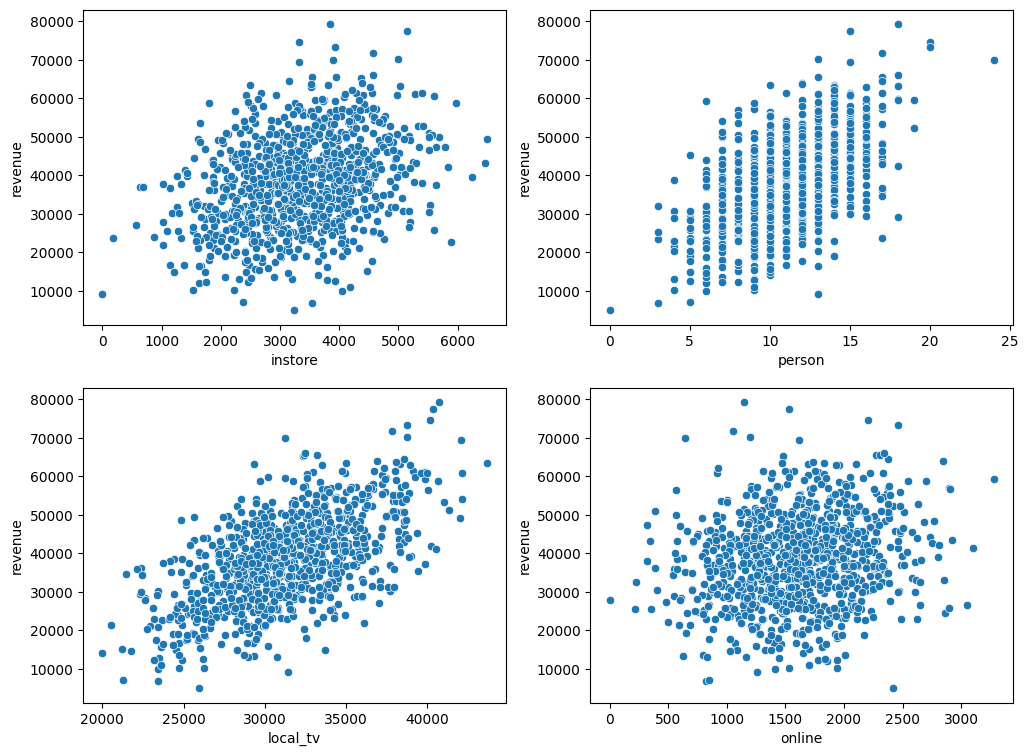

In [641]:
fig, axes = plt.subplots(2, 2, figsize=(12, 9))

#create boxplot in each subplot
sns.scatterplot(y ='revenue', x = 'instore', data = df, ax=axes[0,0])
sns.scatterplot(y ='revenue', x = 'person', data = df, ax=axes[0,1])
sns.scatterplot(y ='revenue', x = 'local_tv', data = df, ax=axes[1,0])
sns.scatterplot(y ='revenue', x = 'online', data = df, ax=axes[1,1])

Text(0.5, 1.0, 'Average revenue of different events')

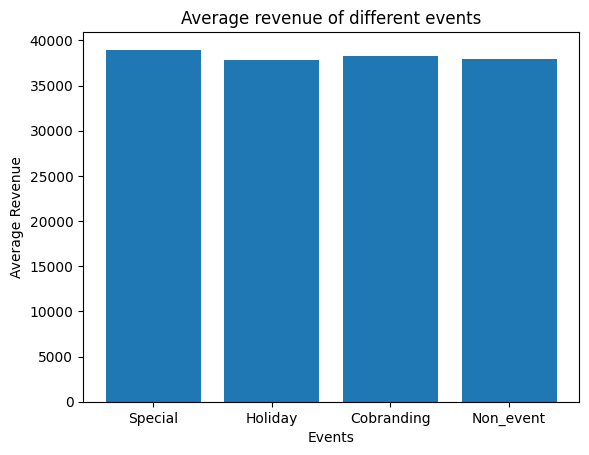

In [642]:
from ipywidgets.widgets.widget_string import Int
special=df[df['event']=='special']
special_rev=special['revenue'].mean()
holiday=df[df['event']=='holiday']
holiday_rev=holiday['revenue'].mean()
cobranding=df[df['event']=='cobranding']
cobranding_rev=cobranding['revenue'].mean()
non_event=df[df['event']=='non_event']
non_event_rev=non_event['revenue'].mean()

events_revenues={"Special": int(special_rev),"Holiday": int(holiday_rev), 'Cobranding':int(cobranding_rev), "Non_event": int(non_event_rev) }
Mean_Revenue=list(events_revenues.values())
events=list(events_revenues.keys())
plt.bar(events, Mean_Revenue)
plt.xlabel('Events')
plt.ylabel('Average Revenue')
plt.title('Average revenue of different events')

**Observation:**There is no great variance between average revenue. However, Special event yield more average revenue than other events.

#Feature Engineering

**HANDLING LOCAL TELEVISION COLUMN**

---



**Checking the number of missing values**

In [643]:
df['local_tv'].isnull().sum()

56

**Checking the mean, median and mode**

In [644]:
print('Skewness', df['local_tv'].skew())
print('Kurtosis', df['local_tv'].kurtosis())
print('Mean:', df['local_tv'].mean())
print('Median', df['local_tv'].median())
print('Mode', df['local_tv'].mode()[0])

Skewness 0.0850322979027817
Kurtosis -0.10913552096582313
Mean: 31324.06110871905
Median 31104.52
Mode 20000.0


**Observation:** The Skewness results illustrates that the data is normally distributed and the kurtosis shows no presence of outliers. The Mean and Median expense of the local tv advertisement doesn't have great variance. However, there is 11000 difference between the value that the company spent the most on local television advertisement and the average amount they spend on local television   advertisement.

**Filling the missing values**

In [645]:
df_mean=pd.DataFrame(df['local_tv'].replace(np.nan,df['local_tv'].mean()))
df_mode=pd.DataFrame(df['local_tv'].replace(np.nan,df['local_tv'].mode()[0]))
df_median=pd.DataFrame(df['local_tv'].replace(np.nan,df['local_tv'].median()))

In [646]:
print('Skewness')
print('')
print('Skewness', df['local_tv'].skew())
print('Mode_skewness', df_mode['local_tv'].skew())
print('Mean_skewness', df_mean['local_tv'].skew())
print('Median_skewness', df_median['local_tv'].skew())
print("")
print('Kurtosis')
print("")
print('Kurtosis', df['local_tv'].kurtosis())
print('Mode_Kurtosis', df_mode['local_tv'].kurtosis())
print('Mean_Kurtosis', df_mean['local_tv'].kurtosis())
print('Median_Kurtosis', df_median['local_tv'].kurtosis())

Skewness

Skewness 0.0850322979027817
Mode_skewness -0.3490963929697198
Mean_skewness 0.08754960872441551
Median_skewness 0.09724520249790865

Kurtosis

Kurtosis -0.10913552096582313
Mode_Kurtosis 0.10828353556972425
Mean_Kurtosis 0.06532306319532655
Median_Kurtosis 0.06545501758960226


**Observation** Filling the missing values with the mean doesn't greatly skew the data. 

**Filling the data with Mean**

In [647]:
df['local_tv']=df['local_tv'].replace(np.nan,df['local_tv'].mean())

**ENCODING CATEGORICAL DATA**

---



In [648]:
df=pd.get_dummies(df, drop_first=True)
df

,revenue,reach,local_tv,online,instore,person,event_holiday,event_non_event,event_special
0,45860.28,2,31694.910000,2115,3296,8,0,1,0
1,63588.23,2,35040.170000,1826,2501,14,0,0,1
2,23272.69,4,30992.820000,1851,2524,6,0,0,1
3,45911.23,2,29417.780000,2437,3049,12,0,0,1
4,36644.23,2,35611.110000,1122,1142,13,0,0,0
...,...,...,...,...,...,...,...,...,...
980,59546.57,2,31233.040000,1849,4335,18,0,0,1
981,31138.22,3,34346.130000,1200,3166,8,0,1,0
982,53704.80,4,31324.061109,1868,1649,15,0,0,0
983,59909.10,3,30215.900000,1532,3702,16,0,0,0


# MODELING

**Spliting the data into Preditors and response variable**

In [649]:
#Response Variable
y = df['revenue']
y=np.array(y)
#Predictor variable(Dropping Response variable)
df= df.drop('revenue', axis=1)


**Standardization of Predictors**

In [650]:
st=StandardScaler()
x=st.fit_transform(df)

**Spliting the data into training and testing data**

In [651]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

**Building Different Models**

In [652]:
#Linear Regression
lr= LinearRegression()
#Lasso Regression
lsr=Lasso()
#Ridge Regression
rr= Ridge()
#Support Vector Machine
sr=SVR(kernel='rbf', gamma='auto')
#Decision Tree
dtr=DecisionTreeRegressor(max_depth=7, random_state=42)
#Random Forest Regressor
rfr = RandomForestRegressor(n_estimators=100, max_depth=7, random_state=42)

**Fitting different model to training data**

In [653]:
#Linear Regression
lr.fit(x_train,y_train)
#Ridge Regression
lsr.fit(x_train,y_train)
#Ridge Regression
rr.fit(x_train,y_train)
#Support Vector Machine
sr.fit(x_train, y_train)
#Decision Tree
dtr.fit(x_train,y_train)
#Random Forest
rfr.fit(x_train,y_train)

RandomForestRegressor(max_depth=7, random_state=42)

**Predicting on the training data**

In [654]:
#Linear Regression
lr_y_train = lr.predict(x_train)
#Lasso Regression
lsr_y_train = lsr.predict(x_train)
#Ridge Regression
rr_y_train = rr.predict(x_train)
#Support Vector Machine
sr_y_train = sr.predict(x_train)
#Decision Tree
dtr_y_train = dtr.predict(x_train)
#Random Forest
rfr_y_train = rfr.predict(x_train)

**Predicting on the Testing data**

In [655]:
#Linear Regression 
lr_y_testing = lr.predict(x_test)
#Lasso Regression 
lsr_y_testing = lsr.predict(x_test)
#Ridge Regression 
rr_y_testing = rr.predict(x_test)
#Support Vector Machine
sr_y_testing = sr.predict(x_test)
#Decision tree Regression 
dtr_y_testing = dtr.predict(x_test)
#Random Forest Regressor 
rfr_y_testing = rfr.predict(x_test)

**R squared score on Training data**

In [656]:
print('Linear Regression:', r2_score(y_train, lr_y_train))
print('Lasso Regression:', r2_score(y_train, lsr_y_train))
print('Ridge Regression:', r2_score(y_train, rr_y_train))
print('Support Vector Machine: :', r2_score(y_train, sr_y_train))
print('Decision Tree:', r2_score(y_train, dtr_y_train))
print('Random Forest:', r2_score(y_train, rfr_y_train))

Linear Regression: 0.8035755119807366
Lasso Regression: 0.8035754505610668
Ridge Regression: 0.8035742649973074
Support Vector Machine: : 0.0029670600825603133
Decision Tree: 0.8501274647256213
Random Forest: 0.873032799996441


**R Squared score on Testing data**

In [657]:
print('Linear Regression:', r2_score(y_test, lr_y_testing))
print('Lasso Regression:', r2_score(y_test, lsr_y_testing))
print('Ridge Regression:', r2_score(y_test, rr_y_testing))
print('Support Vector Machine:', r2_score(y_test, sr_y_testing))
print('Decision Tree:', r2_score(y_test, dtr_y_testing))
print('Random Forest:', r2_score(y_test, rfr_y_testing))

Linear Regression: 0.7964893041421748
Lasso Regression: 0.7965014410090254
Ridge Regression: 0.7965276264346406
Support Vector Machine: 0.001239983458597771
Decision Tree: 0.49796354169593016
Random Forest: 0.7377786714496002


**Root mean squared error on Training data**

In [658]:
print('Linear Regression:', np.sqrt(mean_squared_error(y_train, lr_y_train)))
print('Lasso Regression:', np.sqrt(mean_squared_error(y_train, lsr_y_train)))
print('Ridge Regression:', np.sqrt(mean_squared_error(y_train, rr_y_train)))
print('Support Vector Machine:', np.sqrt(mean_squared_error(y_train, sr_y_train)))
print('Decision Tree:', np.sqrt(mean_squared_error(y_train, dtr_y_train)))
print('Random Forest:', np.sqrt(mean_squared_error(y_train, rfr_y_train)))

Linear Regression: 5229.443614553161
Lasso Regression: 5229.444432146421
Ridge Regression: 5229.460213856148
Support Vector Machine: 11781.821077680059
Decision Tree: 4567.922181738245
Random Forest: 4204.394321645349


**Root mean squared error on Training data**

In [659]:
print('Linear Regression:', np.sqrt(mean_squared_error(y_test, lr_y_testing)))
print('Lasso Regression:', np.sqrt(mean_squared_error(y_test, lsr_y_testing)))
print('Ridge Regression:', np.sqrt(mean_squared_error(y_test, rr_y_testing)))
print('Support Vector Machine:', np.sqrt(mean_squared_error(y_test, sr_y_testing)))
print('Decision Tree:', np.sqrt(mean_squared_error(y_test, dtr_y_testing)))
print('Random Forest:', np.sqrt(mean_squared_error(y_test, rfr_y_testing)))

Linear Regression: 5021.450951203759
Lasso Regression: 5021.30121560876
Ridge Regression: 5020.978144182254
Support Vector Machine: 11124.133168739985
Decision Tree: 7886.843694689961
Random Forest: 5699.93117866699


**Feature Importance**

In [660]:
Features=['Reach', 'Local_tv_Advertisement', 'Online_Advertisement', 'Instore Advertisement', 'Person', 'Holiday_event', 'Non_event', 'Special_event']

Text(0, 0.5, 'Features')

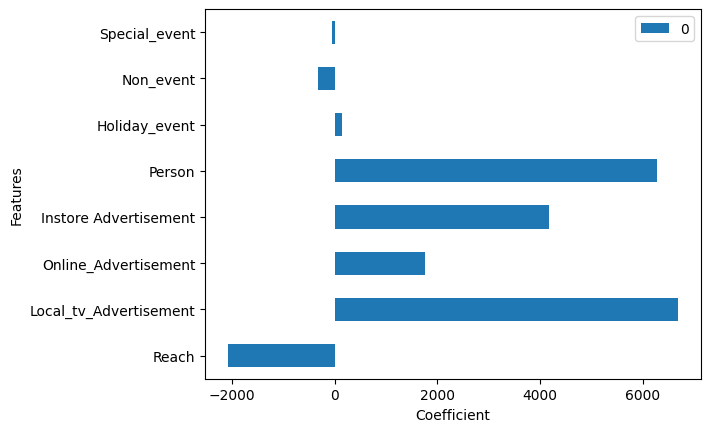

In [661]:
feature=pd.DataFrame(data=list(rr.coef_), index=Features)
feature.plot(kind='barh')
plt.xlabel('Coefficient')
plt.ylabel('Features')

**Observation:** The graph above shows the features that are important on predicting the revenue. Like deduced previously, Local Television Advsertisement and Person Advertisement influence the Revenue positively. Moreover, having no event negatively influence on the revenue. 